In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab_Notebooks/DL-Sigma2021/Deep Learning Project_SIGMA M2_2021"

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/DL-Sigma2021/Deep Learning Project_SIGMA M2_2021


In [5]:
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
from math import ceil

import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import numpy as np
from librosa.core import stft, istft
# import stft
from scipy import fft
from scipy import signal as sig
import soundfile as sf
import librosa
from sklearn.metrics import mean_squared_error

In [7]:
# Load Data
path = "./Audio_Result/"
CleanAduio="Audio_Example.mp3"
NoiseAudio = "babble.wav"
samples1, sample_rate1 = librosa.load(path+CleanAduio)
samples2, sample_rate2  = librosa.load(path+NoiseAudio)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [8]:
samples2 = samples2[:len(samples1)]
#Find length of longest signal
maxlength = max(len(samples1),len(samples2))

#Pad each signal to the length of the longest signal
samples1 = np.pad(samples1, (0, maxlength - len(samples1)), 'constant', constant_values=(0))
samples2 = np.pad(samples2, (0, maxlength - len(samples2)), 'constant', constant_values=(0))

In [9]:
speechPower = sum(samples1**2)
noisePower = sum(samples2**2)
alpha = np.sqrt(speechPower/noisePower)

#combine series together
mixed_series = samples1 + alpha * samples2

In [10]:
#Pad 3 wav files to whole number of seconds
extrapadding = int((ceil(len(mixed_series) / sample_rate1) * sample_rate1) - len(mixed_series))
mixed_series = np.pad(mixed_series, (0,extrapadding), 'constant', constant_values=(0))
samples1 = np.pad(samples1, (0,extrapadding), 'constant', constant_values=(0))
samples2 = np.pad(samples2, (0,extrapadding), 'constant', constant_values=(0))

<Figure size 432x288 with 0 Axes>

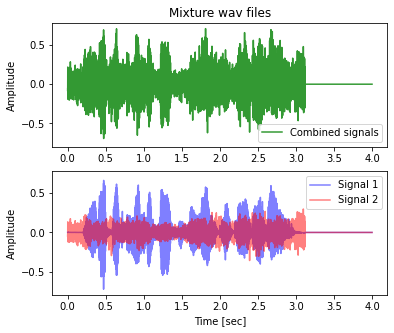

In [11]:
# Show 3 wav files in plot

#Create x axis of time
x = np.arange(0, (len(mixed_series) / sample_rate1), (1 / sample_rate1))

#Show wav file on chart
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(2, figsize=(6,5), sharey=True)

ax1.plot(x, mixed_series, color="green", alpha = 0.8)
ax1.set(title='Mixture wav files', ylabel='Amplitude')
ax1.legend(['Combined signals'])

ax2.plot(x, samples1, color="blue", alpha = 0.5)
ax2.plot(x, samples2, color="red", alpha = 0.5)
ax2.set(xlabel='Time [sec]', ylabel='Amplitude')
ax2.legend(['Signal 1', 'Signal 2'])

#fig.savefig(picturepath + "mixturesignals.png", bbox_inches="tight")
plt.show()
plt.close(fig)

In [12]:
# Compute the STFT of the 3 wav files

#Length of each segment. Defaults to 256. Set to 0.05 of a second
nperseg = sample_rate1 / 50

#Get stft of 3 wav files
f1, t1, Zsamples1 = sig.stft(samples1, fs=sample_rate1, nperseg=nperseg)
f2, t2, Zsamples2 = sig.stft(samples2, fs=sample_rate1, nperseg=nperseg)
fmixed, tmixed, Zmixed_series = sig.stft(mixed_series, fs=sample_rate1, nperseg=nperseg)

<Figure size 432x288 with 0 Axes>

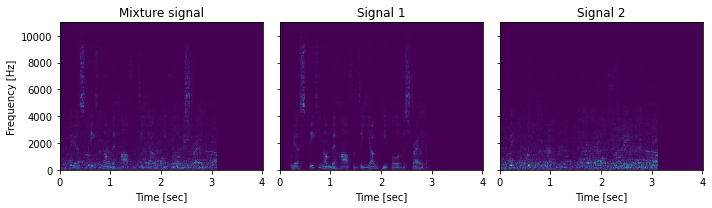

In [13]:
# Plot magnitude of 3 wav files

# Plot Spectrogram
fig = plt.figure() 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3), sharey=True)

ax1.pcolormesh(tmixed, fmixed, np.abs(Zmixed_series))
ax1.set(title='Mixture signal', xlabel='Time [sec]', ylabel='Frequency [Hz]')

ax2.pcolormesh(t1, f1, np.abs(Zsamples1))
ax2.set(title='Signal 1', xlabel='Time [sec]')

ax3.pcolormesh(t2, f2, np.abs(Zsamples2))
ax3.set(title='Signal 2', xlabel='Time [sec]')

plt.tight_layout()
#fig.savefig(picturepath + "spectrograms.png", bbox_inches="tight")
plt.show()
plt.close(fig)

In [14]:
# Create mask and apply it to the signal
# Create IBM for signal 1 by calculating SNR of signal 1 vs mixture signal

#Choose sample to create mask for
Zsample = Zsamples1
sample = samples1

#Calculate signal to noise ratio of clean signal versus combined signal
snr = np.divide(np.real(np.abs(Zsample)), np.real(np.abs(Zmixed_series)))
#round snr to 0 or 1 to create binary mask
mask = np.around(snr, 0)

#convert all nan in mask to 1 (it shouldnt matter if this is 0 or 1)
mask[np.isnan(mask)] = 1
 
#replace all values over 1 with 1
mask[mask > 1] = 1
     
#check to see what maximum value in array is     
np.amax(mask)

#Element-wise multiply mask with mixed signal t-f signal
Zsamplesmaked = np.multiply(Zmixed_series, mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


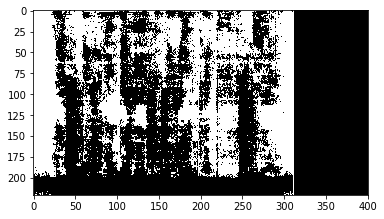

In [15]:
# Show the mask

fig = plt.figure() 
plt.imshow(mask, cmap='Greys', interpolation='none')

#fig.savefig(picturepath + "mask.png", bbox_inches="tight")
plt.show()
plt.close(fig)

In [16]:
# convert back to a time series via inverse STFT
_, samplesrec = sig.istft(Zsamplesmaked, sample_rate1)

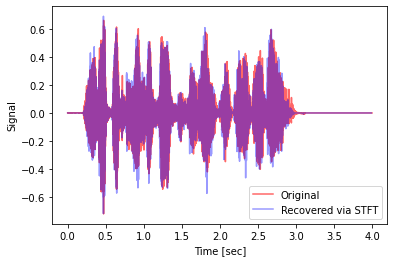

In [20]:
# Compare the original wav with recovered wav

fig = plt.figure()
plt.plot(x, sample, color="red", alpha = 0.6)
plt.plot(x[:len(samplesrec)], samplesrec, color="blue", alpha = 0.4)
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(['Original', 'Recovered via STFT'])
#fig.savefig(picturepath + "recoverdsignal.png", bbox_inches="tight")
plt.show()
plt.close(fig)

In [ ]:
# Save recovered wav file
# Save combined series to wav file
wavfile.write('recovered.wav', sample_rate1, samplesrec)
wavfile.write('Clean and noise.wav', sample_rate1, mixed_series)